# Decision Tree Classification

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

In [2]:
# import 
df = pd.read_csv('../trainDataset.csv')
df = df[~(df == 999).any(axis=1)]
df.drop('ID', axis=1, inplace=True)

for i in range(12, len(df.columns)):
    df.columns.values[i] = 'img_' + str(i)

df = df.reset_index()

In [3]:
threshold = 4 # standard deviations from mean (99.7% of data)
for i, col_name in enumerate(df.columns[13:]):
    col = df[col_name]
    mean = np.mean(col)
    std = np.std(col)
    for j, x in enumerate(col):
        z = (x - mean) / std
        if z > threshold:
            df.iloc[j, i] = mean

In [4]:
# Assign features to X
X = df.drop('pCR (outcome)', axis=1).drop('RelapseFreeSurvival (outcome)', axis=1)
# Assign labels to y
y = df['pCR (outcome)']

In [5]:
X.drop('index', axis=1, inplace=True)

In [6]:
from sklearn.preprocessing import StandardScaler 

# Normalise the categorical features to use zero mean normalisation
scaler = StandardScaler()
Xs = scaler.fit_transform(X) 

In [7]:
from sklearn.decomposition import PCA

feature_names = list(X.columns) 
pca = PCA(n_components=0.90) # retain 90% of variance
img_pca = pca.fit_transform(Xs[:,12:])
print("N components:",pca.n_components_)

keep = pca.n_components_
img_pca = img_pca[:,:keep] # retain the first 3 components
cols = ['pca_' + str(i+1) for i in range(keep)]
df_img_pca = pd.DataFrame(img_pca, columns=cols)

col_names = X.columns[:10]
Xs_pca = pd.concat([pd.DataFrame(Xs[:,:10], columns=col_names), df_img_pca], axis=1)

N components: 14


Split data before oversampling for testing true performance on unaltered population

In [8]:
_, Xs_test_origiinal, _, y_test_original = train_test_split(Xs_pca, y, test_size=0.2, random_state=1, stratify=y)

Perform SMOTE over-sampling to boost population of minority class (1)

In [9]:
from imblearn.over_sampling import SMOTE

Xs_pca_resampled, y_resampled = SMOTE().fit_resample(Xs_pca, y)

Split data into training and testing sets for quick evaluation

In [10]:
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs_pca_resampled, y_resampled, test_size=0.2, random_state=1, stratify=y_resampled)

Use GridSearch to exhaustively tune hyper-parameters of decision tree

In [11]:
from sklearn.tree import DecisionTreeClassifier

In [12]:
scoring = {"AUC": "roc_auc", "Accuracy" : "accuracy"}

params = {
    'min_samples_split': list(range(2,80,2)),
    'max_depth' : list(range(2,10))
}
search = GridSearchCV(
    estimator=DecisionTreeClassifier(), 
    param_grid=params,
    scoring=scoring,
    refit='Accuracy',
    verbose=2,
    cv=5,
    return_train_score=True
)

search.fit(Xs_train, y_train)
results = search.cv_results_
search.best_estimator_

Fitting 5 folds for each of 312 candidates, totalling 1560 fits
[CV] END ...................max_depth=2, min_samples_split=2; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=2; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=2; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=2; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=2; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=4; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=4; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=4; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=4; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=4; total time=   0.0s
[CV] END ...................max_depth=2, min_samples_split=6; total time=   0.0s
[CV] END ...................max_depth=2, min_

DecisionTreeClassifier(max_depth=9)

In [13]:
tree = search.best_estimator_

In [16]:

# Score decision tree model
kfold_scores = cross_val_score(tree, X, y, scoring='accuracy', cv=5)
print('Decision Tree:\t', kfold_scores)

Decision Tree:	 [0.65384615 0.61538462 0.69230769 0.61538462 0.62820513]


In [17]:
tree.fit(Xs_train, y_train)
y_predict = tree.predict(Xs_test)

Text(0.5, 1.05, 'Best Decision Tree\n')

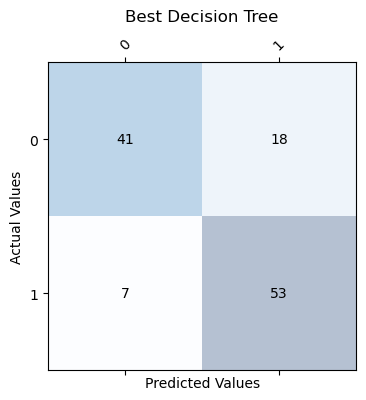

In [23]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_predict)
# Plot confusion matrix, 
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
 for j in range(cm.shape[1]):
     ax.text(x=j, y=i,
         s=cm[i, j], 
         va='center', ha='center')
classes=["0","1"]
tick_marks = np.arange(len(classes))
fig = plt.gcf()
fig.set_size_inches(4,4)
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values',)
plt.ylabel('Actual Values', )
plt.title('Best Decision Tree\n')

In [43]:
import sklearn.metrics as metrics

print(
    "Accuracy:\t", metrics.accuracy_score(y_predict, y_test),
    "\nPrecision:\t", metrics.precision_score(y_predict, y_test)
)

Accuracy:	 0.773109243697479 
Precision:	 0.7833333333333333
